<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/selfattention_50epoch_flower_D_sa_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.9 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 91.5MB/s]


In [ ]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf , attention = True)
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, attention = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, attention = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:48<00:00,  2.12it/s]


epoch: 0, lossD:1.3296640545708462, lossG:19.588926167164033,lossG_fake:14.17517233936532, lossG_real:5.413753790762818 ,equality:8.761418548602503


evaluate:218.75518798828125,kid_mean:0.18426117300987244, kid_std:0.026013853028416634,kid_:(tensor(0.1843), tensor(0.0260))


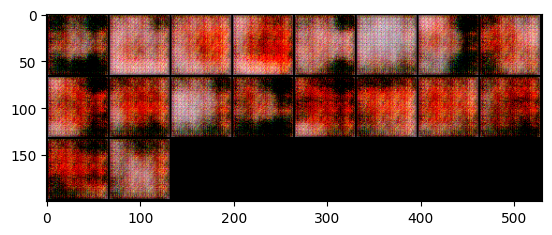

100%|██████████| 103/103 [00:09<00:00, 10.71it/s]


epoch: 1, lossD:0.7937897967301237, lossG:9.293446948227373,lossG_fake:5.41266405582428, lossG_real:3.8807828695450013 ,equality:1.5318811862792785


evaluate:150.69332885742188,kid_mean:0.10816679894924164, kid_std:0.03919408470392227,kid_:(tensor(0.1082), tensor(0.0392))


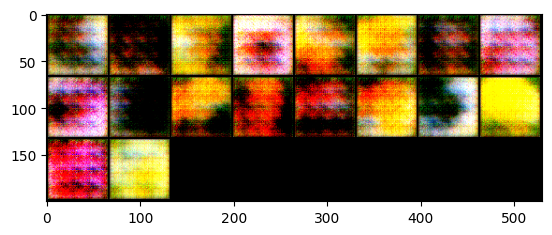

100%|██████████| 103/103 [00:09<00:00, 10.63it/s]


epoch: 2, lossD:1.1207172416367577, lossG:7.224328740129193,lossG_fake:4.202611424969238, lossG_real:3.0217173278910443 ,equality:1.1808940970781934


evaluate:138.12789916992188,kid_mean:0.08924368023872375, kid_std:0.03455245867371559,kid_:(tensor(0.0892), tensor(0.0346))


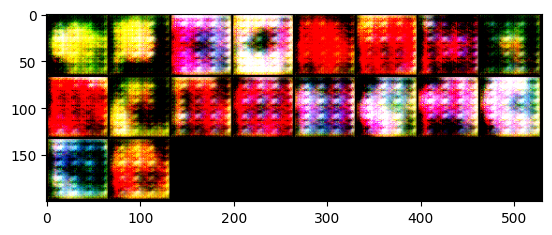

100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


epoch: 3, lossD:0.9826602307916845, lossG:7.695904282690252,lossG_fake:4.568682354630776, lossG_real:3.127221964227343 ,equality:1.4414603904034333


evaluate:145.34852600097656,kid_mean:0.10171787440776825, kid_std:0.04004839062690735,kid_:(tensor(0.1017), tensor(0.0400))


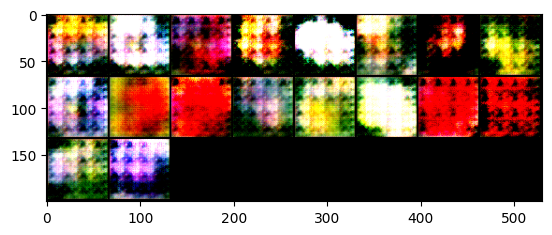

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 4, lossD:1.0909658910580051, lossG:6.910610523038698,lossG_fake:4.0861780666610565, lossG_real:2.824432467951358 ,equality:1.2617455987096986


evaluate:141.68138122558594,kid_mean:0.10595479607582092, kid_std:0.04974369704723358,kid_:(tensor(0.1060), tensor(0.0497))


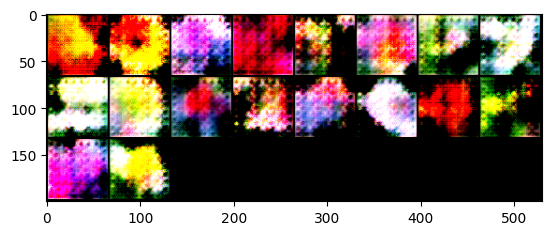

100%|██████████| 103/103 [00:09<00:00, 10.43it/s]


epoch: 5, lossD:0.9927808667704897, lossG:7.011727907125232,lossG_fake:4.136246936992534, lossG_real:2.8754809539294937 ,equality:1.2607659830630404


evaluate:134.28305053710938,kid_mean:0.08950239419937134, kid_std:0.04230981320142746,kid_:(tensor(0.0895), tensor(0.0423))


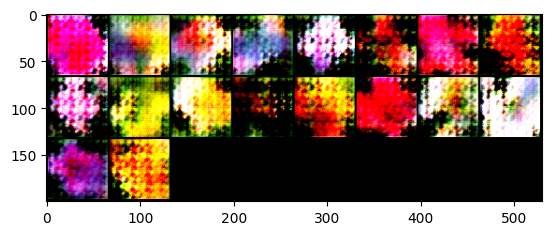

100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


epoch: 6, lossD:0.9908820746593106, lossG:6.8466285131510025,lossG_fake:4.073859721132853, lossG_real:2.7727687804444323 ,equality:1.3010909406884203


evaluate:133.25526428222656,kid_mean:0.09190797805786133, kid_std:0.03964883089065552,kid_:(tensor(0.0919), tensor(0.0396))


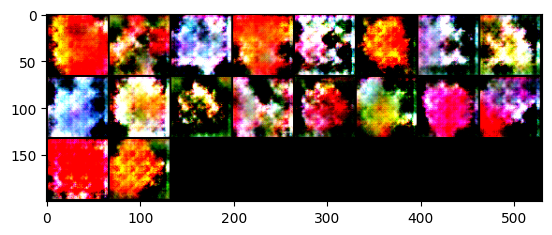

100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


epoch: 7, lossD:0.9336479487783701, lossG:6.940296219390573,lossG_fake:3.9849787076700083, lossG_real:2.9553174897305015 ,equality:1.0296612179395068


evaluate:130.76998901367188,kid_mean:0.08289072662591934, kid_std:0.039379313588142395,kid_:(tensor(0.0829), tensor(0.0394))


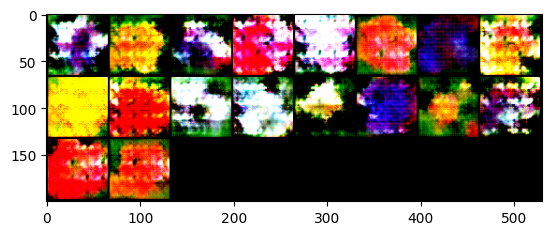

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 8, lossD:0.9609508207700785, lossG:6.646577483241998,lossG_fake:3.839446246045307, lossG_real:2.8071312238869157 ,equality:1.0323150221583912


evaluate:134.0948486328125,kid_mean:0.08020279556512833, kid_std:0.0392899364233017,kid_:(tensor(0.0802), tensor(0.0393))


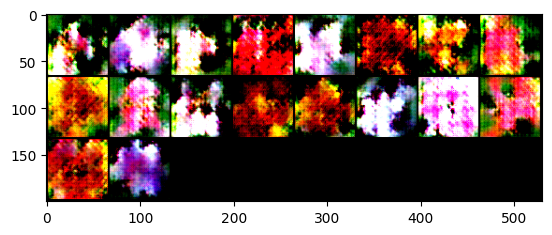

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 9, lossD:0.8942687390643416, lossG:6.903302748226425,lossG_fake:4.0371882603006455, lossG_real:2.866114502971612 ,equality:1.1710737573290335


evaluate:134.42474365234375,kid_mean:0.08071354031562805, kid_std:0.04649655893445015,kid_:(tensor(0.0807), tensor(0.0465))


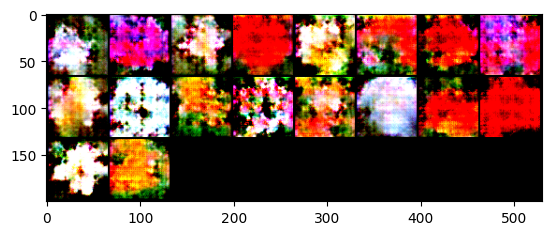

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 10, lossD:0.9523122654956522, lossG:6.47164536911307,lossG_fake:3.6581866365034603, lossG_real:2.813458741289898 ,equality:0.8447278952135622


evaluate:136.74876403808594,kid_mean:0.09781942516565323, kid_std:0.04595551639795303,kid_:(tensor(0.0978), tensor(0.0460))


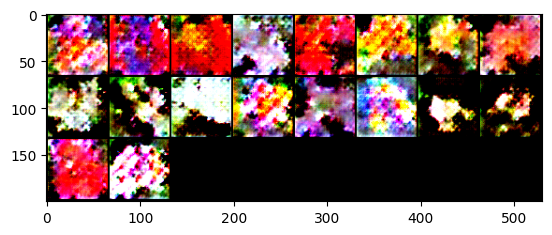

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 11, lossD:0.9309240657546856, lossG:6.4916413270154045,lossG_fake:3.641961309516314, lossG_real:2.849680029651494 ,equality:0.7922812798648202


evaluate:133.22352600097656,kid_mean:0.09101781994104385, kid_std:0.04880403354763985,kid_:(tensor(0.0910), tensor(0.0488))


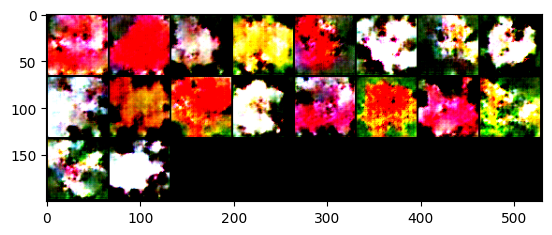

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 12, lossD:0.8794782322297976, lossG:6.791766787038266,lossG_fake:3.7489012567308344, lossG_real:3.0428654950799294 ,equality:0.706035761650905


evaluate:130.1579132080078,kid_mean:0.09111859649419785, kid_std:0.047601278871297836,kid_:(tensor(0.0911), tensor(0.0476))


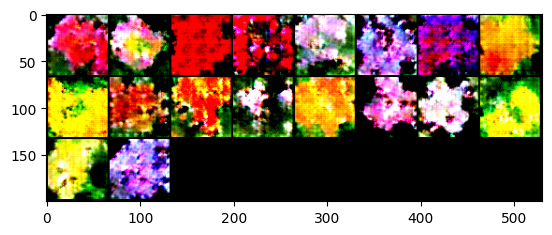

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 13, lossD:0.9950352224331458, lossG:6.632938204459774,lossG_fake:3.6652360726328728, lossG_real:2.9677021335629585 ,equality:0.6975339390699142


evaluate:126.13980865478516,kid_mean:0.08463015407323837, kid_std:0.04453597217798233,kid_:(tensor(0.0846), tensor(0.0445))


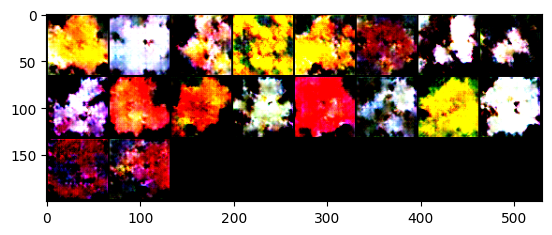

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 14, lossD:0.820822218812785, lossG:6.7109324029348425,lossG_fake:3.63234416663068, lossG_real:3.0785882351467913 ,equality:0.5537559314838889


evaluate:127.7857894897461,kid_mean:0.08591167628765106, kid_std:0.0493360310792923,kid_:(tensor(0.0859), tensor(0.0493))


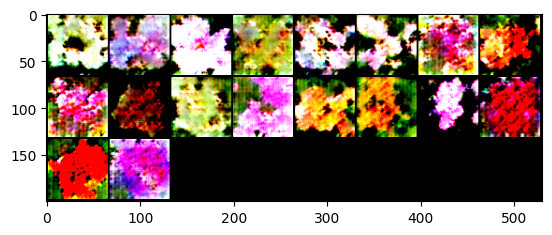

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 15, lossD:0.9024041267563996, lossG:6.76211923302956,lossG_fake:3.73166517956743, lossG_real:3.030454041309727 ,equality:0.7012111382577029


evaluate:122.96174621582031,kid_mean:0.09937692433595657, kid_std:0.0485910102725029,kid_:(tensor(0.0994), tensor(0.0486))


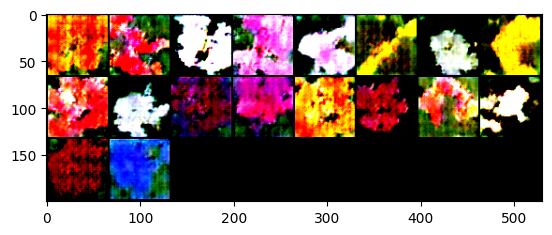

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 16, lossD:0.8207518082220577, lossG:6.7042124850078695,lossG_fake:3.586622943577257, lossG_real:3.1175895535830156 ,equality:0.4690333899942414


evaluate:120.2686538696289,kid_mean:0.08851955085992813, kid_std:0.04462609067559242,kid_:(tensor(0.0885), tensor(0.0446))


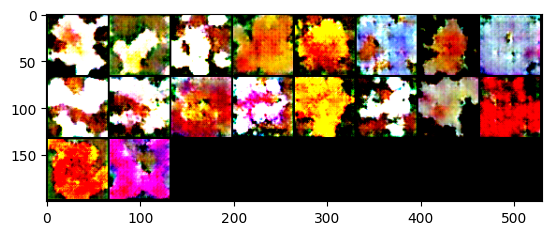

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 17, lossD:0.7846261537226947, lossG:6.660107520020124,lossG_fake:3.556448012879751, lossG_real:3.103659495566655 ,equality:0.4527885173130959


evaluate:121.47525024414062,kid_mean:0.09324073046445847, kid_std:0.048666272312402725,kid_:(tensor(0.0932), tensor(0.0487))


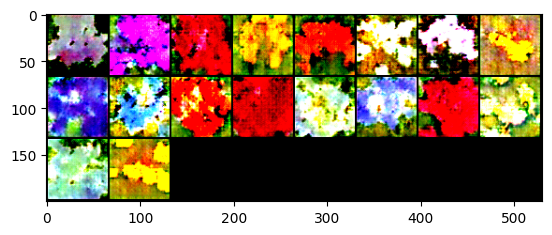

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 18, lossD:0.6894947352629264, lossG:7.298333871711805,lossG_fake:3.8976675457167396, lossG_real:3.400666292431285 ,equality:0.4970012532854544


evaluate:120.20147705078125,kid_mean:0.08472840487957001, kid_std:0.04414718970656395,kid_:(tensor(0.0847), tensor(0.0441))


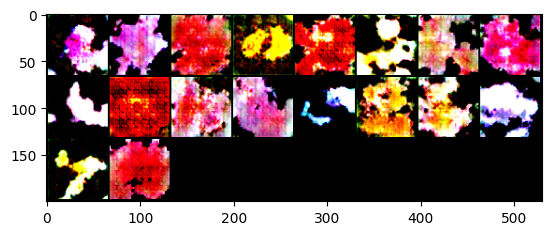

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 19, lossD:0.7657080583491371, lossG:7.179481423016891,lossG_fake:3.8492493941945938, lossG_real:3.330232033451784 ,equality:0.5190173607428097


evaluate:120.93850708007812,kid_mean:0.08349166065454483, kid_std:0.04281995818018913,kid_:(tensor(0.0835), tensor(0.0428))


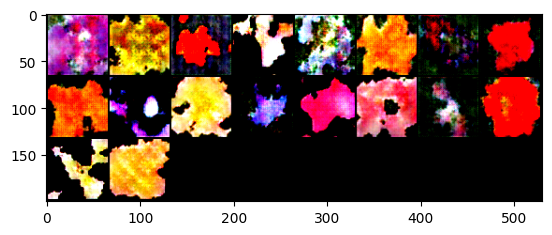

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 20, lossD:0.6212546219235485, lossG:7.314317393071443,lossG_fake:3.888496949834731, lossG_real:3.4258204582825447 ,equality:0.46267649155218615


evaluate:122.32474517822266,kid_mean:0.09621463716030121, kid_std:0.05220292881131172,kid_:(tensor(0.0962), tensor(0.0522))


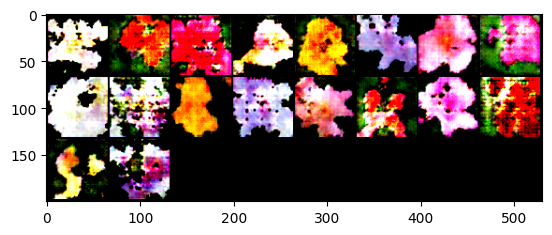

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 21, lossD:0.5669962162676366, lossG:7.389169095789344,lossG_fake:3.885700714240954, lossG_real:3.503468364187815 ,equality:0.38223235005313905


evaluate:119.32380676269531,kid_mean:0.08340879529714584, kid_std:0.04389671981334686,kid_:(tensor(0.0834), tensor(0.0439))


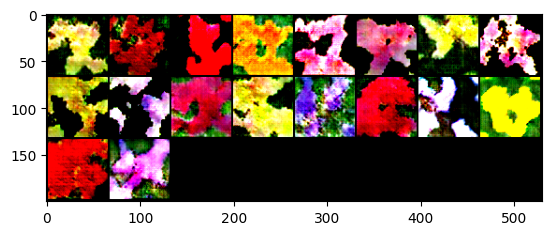

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 22, lossD:0.6106790128046448, lossG:7.499887184031959,lossG_fake:4.011366726704014, lossG_real:3.4885204567492587 ,equality:0.5228462699547554


evaluate:119.77705383300781,kid_mean:0.08614030480384827, kid_std:0.04654465988278389,kid_:(tensor(0.0861), tensor(0.0465))


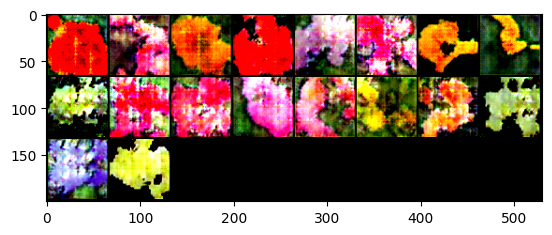

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 23, lossD:0.5705021725587763, lossG:7.890421904406502,lossG_fake:4.233754963550753, lossG_real:3.6566669399877196 ,equality:0.5770880235630336


evaluate:120.5103530883789,kid_mean:0.095207579433918, kid_std:0.04609910026192665,kid_:(tensor(0.0952), tensor(0.0461))


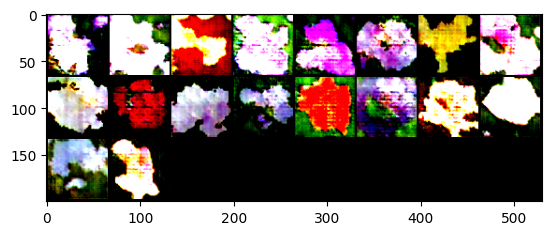

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 24, lossD:0.3797978268556514, lossG:8.07018388359292,lossG_fake:4.359172105789185, lossG_real:3.711011753498929 ,equality:0.6481603522902555


evaluate:121.97914123535156,kid_mean:0.08816583454608917, kid_std:0.04432078078389168,kid_:(tensor(0.0882), tensor(0.0443))


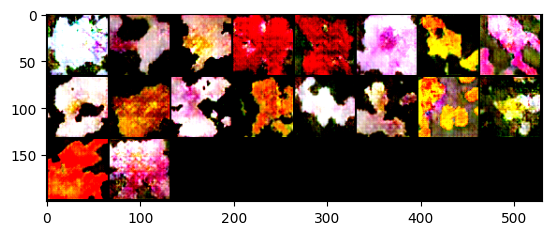

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 25, lossD:0.5641649155108963, lossG:7.973069399305918,lossG_fake:4.255883965098742, lossG_real:3.717185355505897 ,equality:0.5386986095928452


evaluate:120.59910583496094,kid_mean:0.08866632729768753, kid_std:0.05201723426580429,kid_:(tensor(0.0887), tensor(0.0520))


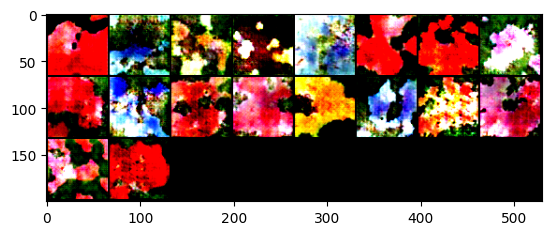

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 26, lossD:0.41139881394224836, lossG:7.982758452591387,lossG_fake:4.156223065644792, lossG_real:3.8265353394943533 ,equality:0.3296877261504383


evaluate:118.01686096191406,kid_mean:0.08275511860847473, kid_std:0.04256006330251694,kid_:(tensor(0.0828), tensor(0.0426))


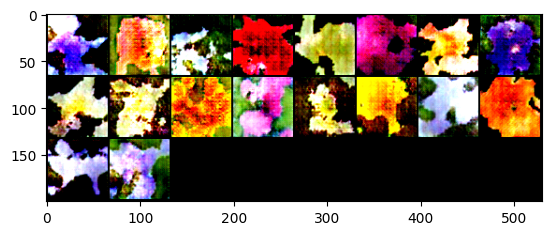

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 27, lossD:0.33194788125822844, lossG:8.38481170228384,lossG_fake:4.400831231793154, lossG_real:3.9839805063692113 ,equality:0.4168507254239424


evaluate:118.74646759033203,kid_mean:0.08435337245464325, kid_std:0.03912382572889328,kid_:(tensor(0.0844), tensor(0.0391))


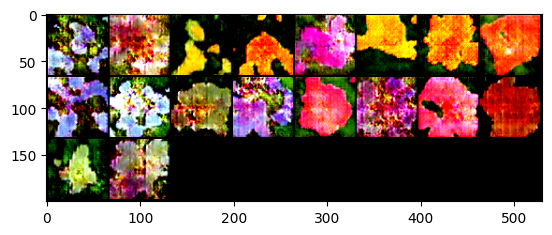

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 28, lossD:0.31762558766143417, lossG:8.874326372609556,lossG_fake:4.699689650998532, lossG_real:4.174636723925766 ,equality:0.5250529270727657


evaluate:120.22115325927734,kid_mean:0.0897001251578331, kid_std:0.043504614382982254,kid_:(tensor(0.0897), tensor(0.0435))


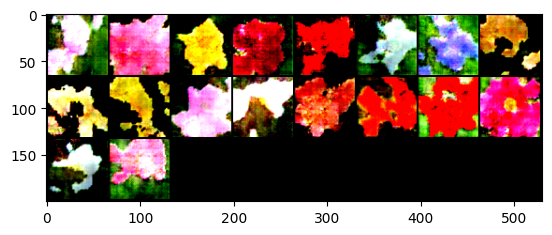

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 29, lossD:0.2854020944208775, lossG:8.838702998115021,lossG_fake:4.659745270766101, lossG_real:4.178957671795077 ,equality:0.4807875989710242


evaluate:119.877197265625,kid_mean:0.09214616566896439, kid_std:0.04377755522727966,kid_:(tensor(0.0921), tensor(0.0438))


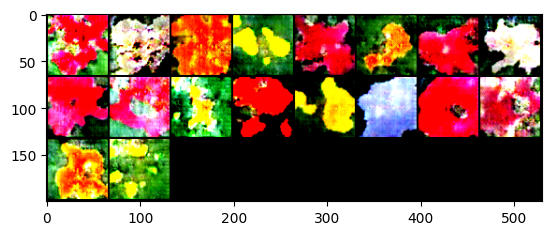

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 30, lossD:0.24775928727269753, lossG:9.06211049811354,lossG_fake:4.720412253176124, lossG_real:4.34169826808485 ,equality:0.37871398509127374


evaluate:118.17961883544922,kid_mean:0.07582993805408478, kid_std:0.03995179012417793,kid_:(tensor(0.0758), tensor(0.0400))


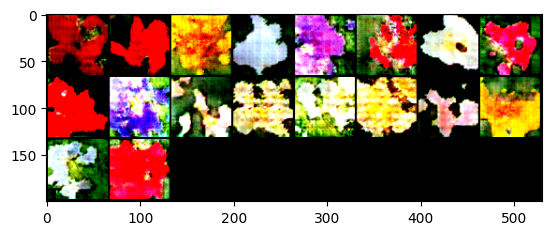

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 31, lossD:0.3089473559656768, lossG:9.277605223424226,lossG_fake:4.857587718847886, lossG_real:4.420017503997655 ,equality:0.43757021485023095


evaluate:117.80070495605469,kid_mean:0.09047958254814148, kid_std:0.045746274292469025,kid_:(tensor(0.0905), tensor(0.0457))


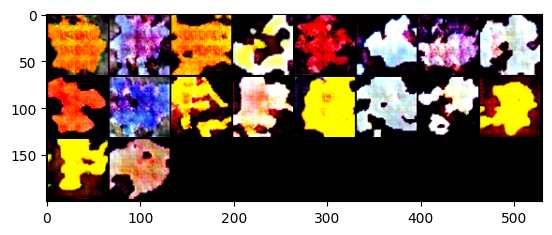

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 32, lossD:0.28809420558289417, lossG:9.30603687971541,lossG_fake:4.850049653678265, lossG_real:4.455987217356857 ,equality:0.39406243632140736


evaluate:116.66712188720703,kid_mean:0.08715853095054626, kid_std:0.04228530079126358,kid_:(tensor(0.0872), tensor(0.0423))


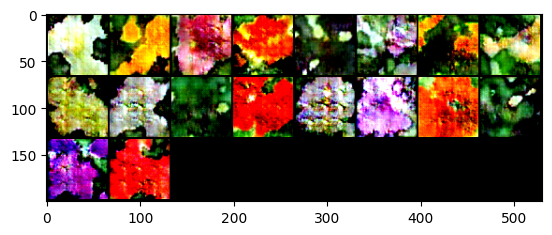

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 33, lossD:0.2448046811431357, lossG:10.154218442231706,lossG_fake:5.419417353509699, lossG_real:4.734801074833546 ,equality:0.6846162786761534


evaluate:116.20580291748047,kid_mean:0.08845289051532745, kid_std:0.04306443780660629,kid_:(tensor(0.0885), tensor(0.0431))


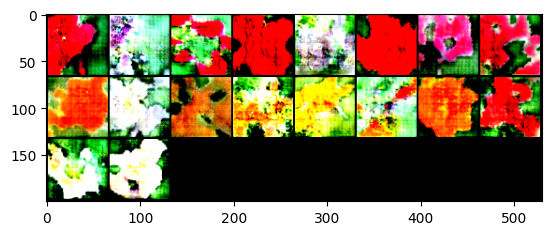

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 34, lossD:0.21863956250322675, lossG:10.206199812657625,lossG_fake:5.332901521793847, lossG_real:4.8732982607721125 ,equality:0.45960326102173443


evaluate:114.81065368652344,kid_mean:0.08322195708751678, kid_std:0.05050613731145859,kid_:(tensor(0.0832), tensor(0.0505))


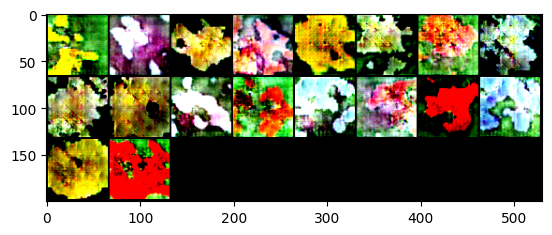

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 35, lossD:0.19704649315297024, lossG:10.264805488216068,lossG_fake:5.350850800866062, lossG_real:4.91395469776635 ,equality:0.43689610309971183


evaluate:115.69048309326172,kid_mean:0.0779101774096489, kid_std:0.04352421686053276,kid_:(tensor(0.0779), tensor(0.0435))


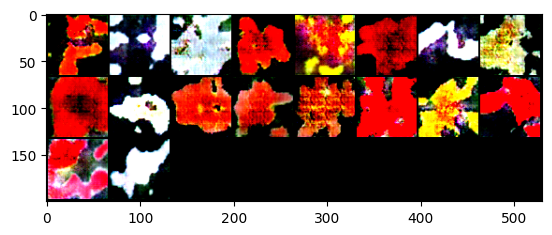

100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


epoch: 36, lossD:0.356801119081459, lossG:10.097095359876318,lossG_fake:5.240216138004099, lossG_real:4.856879173551948 ,equality:0.38333696445215093


evaluate:115.74671173095703,kid_mean:0.0922713503241539, kid_std:0.04971872642636299,kid_:(tensor(0.0923), tensor(0.0497))


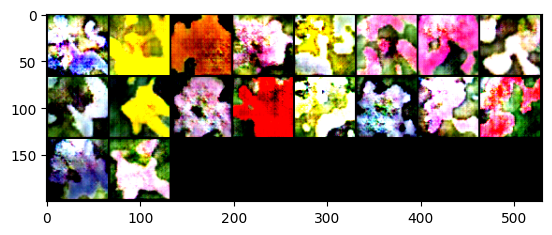

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 37, lossD:0.3558374201173632, lossG:10.000595842750327,lossG_fake:5.105435517517108, lossG_real:4.895160256080257 ,equality:0.21027526143685105


evaluate:115.07640838623047,kid_mean:0.08215750008821487, kid_std:0.04238618537783623,kid_:(tensor(0.0822), tensor(0.0424))


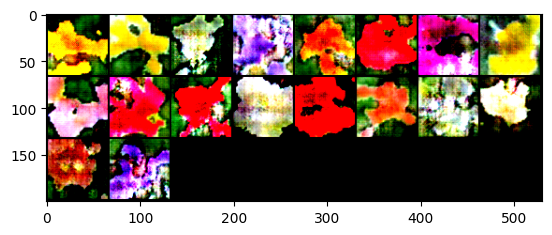

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 38, lossD:0.1512556563411812, lossG:10.015478763765502,lossG_fake:5.281735302175133, lossG_real:4.733743496311521 ,equality:0.547991805863612


evaluate:113.54157257080078,kid_mean:0.07490890473127365, kid_std:0.03878725692629814,kid_:(tensor(0.0749), tensor(0.0388))


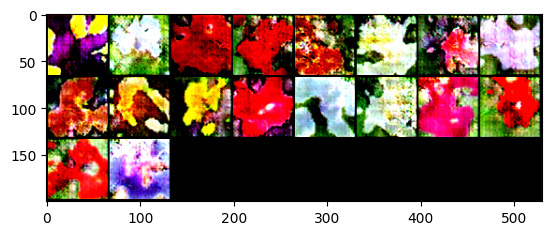

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 39, lossD:0.14221084158578254, lossG:10.28593842034201,lossG_fake:5.348180511622753, lossG_real:4.937757929551949 ,equality:0.4104225820708045


evaluate:114.87738800048828,kid_mean:0.08119161427021027, kid_std:0.04151776060461998,kid_:(tensor(0.0812), tensor(0.0415))


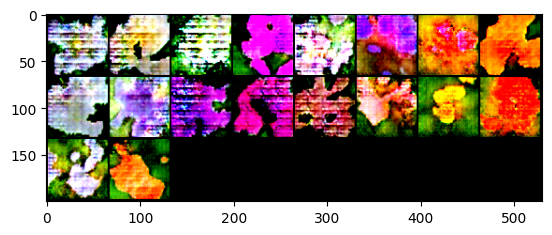

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 40, lossD:0.18757358423063478, lossG:10.743784969292799,lossG_fake:5.457481638899127, lossG_real:5.286303266738225 ,equality:0.17117837216090237


evaluate:114.83633422851562,kid_mean:0.0827326774597168, kid_std:0.0379527285695076,kid_:(tensor(0.0827), tensor(0.0380))


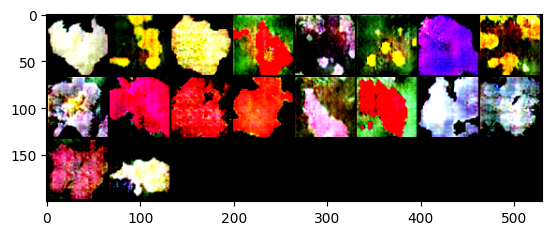

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 41, lossD:0.23274969103411564, lossG:10.85394423216292,lossG_fake:5.669157579107192, lossG_real:5.1847866461114975 ,equality:0.4843709329956942
evaluate:115.5923843383789,kid_mean:0.08099126070737839, kid_std:0.04215145483613014,kid_:(tensor(0.0810), tensor(0.0422))


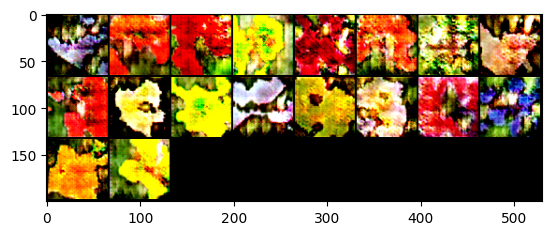

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 42, lossD:0.1720876274720847, lossG:11.136205006571648,lossG_fake:5.855263653310757, lossG_real:5.280941384509929 ,equality:0.5743222688008283


evaluate:111.43669128417969,kid_mean:0.07895474135875702, kid_std:0.04390176758170128,kid_:(tensor(0.0790), tensor(0.0439))


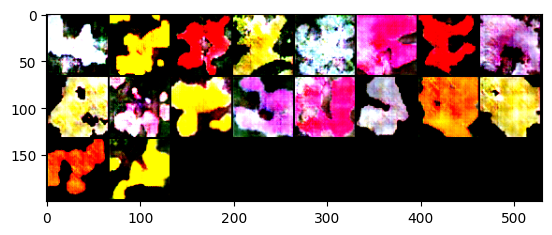

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 43, lossD:0.15645077717897382, lossG:11.010222222041158,lossG_fake:5.87185489321218, lossG_real:5.138367289478339 ,equality:0.7334876037338409


evaluate:113.24405670166016,kid_mean:0.08698505163192749, kid_std:0.04141360893845558,kid_:(tensor(0.0870), tensor(0.0414))


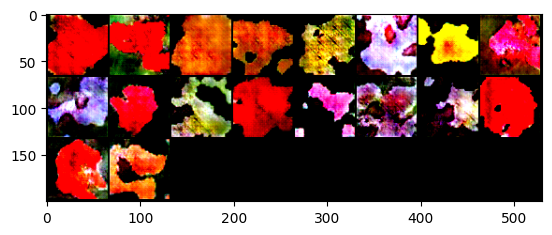

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 44, lossD:0.21604000187469918, lossG:11.289068092420264,lossG_fake:5.786342078042262, lossG_real:5.502726003961656 ,equality:0.28361607408060596


evaluate:113.17627716064453,kid_mean:0.07902701944112778, kid_std:0.03996646776795387,kid_:(tensor(0.0790), tensor(0.0400))


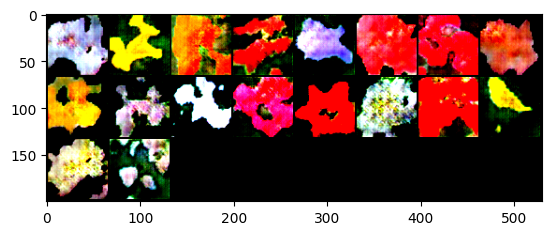

100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


epoch: 45, lossD:0.13725579273208832, lossG:11.549243547384021,lossG_fake:5.997764138342108, lossG_real:5.551479427559862 ,equality:0.44628471078224585


evaluate:113.35025787353516,kid_mean:0.08054784685373306, kid_std:0.0402204804122448,kid_:(tensor(0.0805), tensor(0.0402))


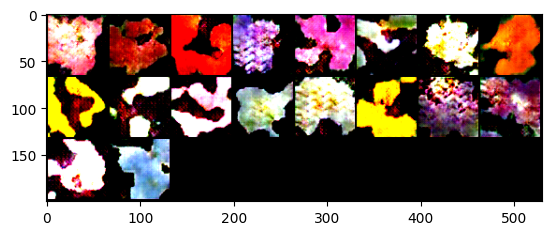

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 46, lossD:0.13279648246334017, lossG:11.42536160552386,lossG_fake:5.92596279533164, lossG_real:5.499398823501994 ,equality:0.4265639718296459


evaluate:114.34778594970703,kid_mean:0.08270066231489182, kid_std:0.046874817460775375,kid_:(tensor(0.0827), tensor(0.0469))


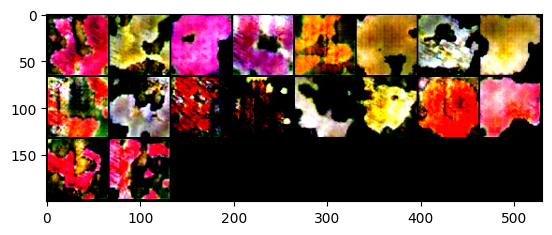

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 47, lossD:0.15687315999665885, lossG:11.441857300915764,lossG_fake:5.967754407993798, lossG_real:5.47410288098657 ,equality:0.4936515270072279


evaluate:114.86792755126953,kid_mean:0.09110808372497559, kid_std:0.047484029084444046,kid_:(tensor(0.0911), tensor(0.0475))


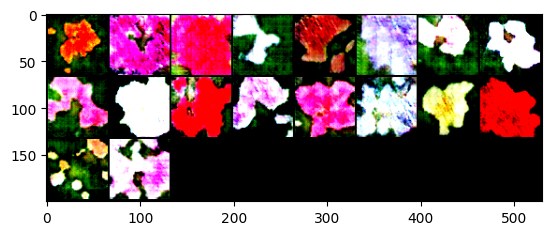

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 48, lossD:0.1858571656229137, lossG:11.137997034683968,lossG_fake:5.9127362897095175, lossG_real:5.225260755969483 ,equality:0.6874755337400345


evaluate:113.82412719726562,kid_mean:0.08274892717599869, kid_std:0.03821568563580513,kid_:(tensor(0.0827), tensor(0.0382))


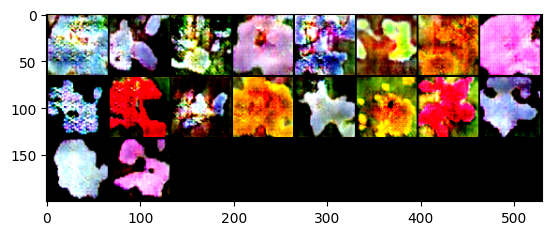

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 49, lossD:0.1275488036928825, lossG:11.03107027405674,lossG_fake:5.691111741714107, lossG_real:5.3399585612769265 ,equality:0.3511531804371808


evaluate:113.95552062988281,kid_mean:0.08122935891151428, kid_std:0.05294175446033478,kid_:(tensor(0.0812), tensor(0.0529))


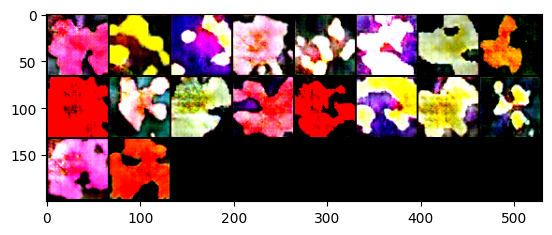

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

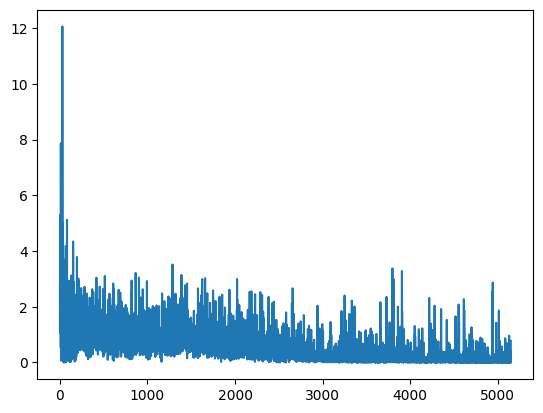

In [ ]:
plt.plot(raw_lossesD)

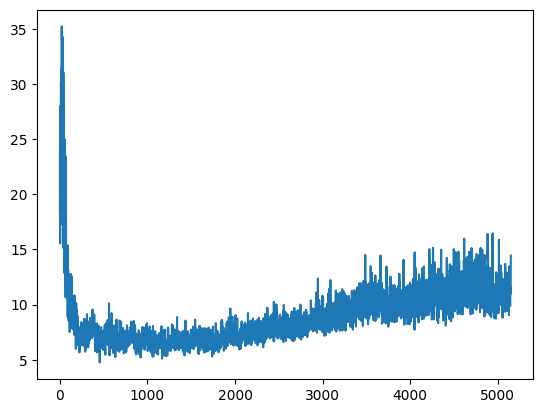

In [ ]:
plt.plot(raw_lossesG)

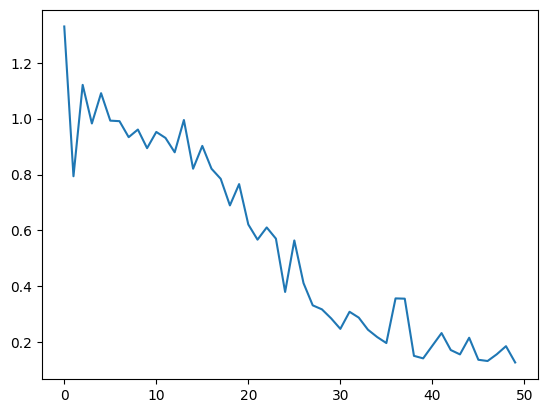

In [ ]:
plt.plot(lossesD)

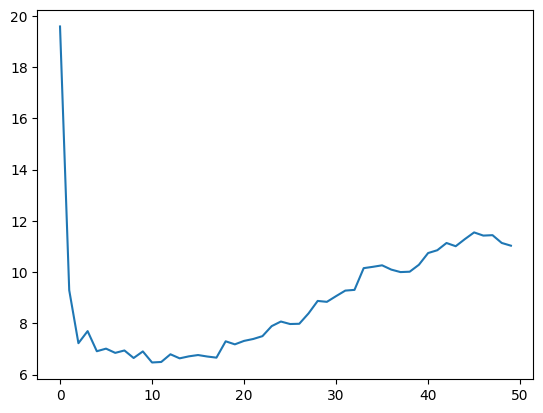

In [ ]:
plt.plot(lossesG)

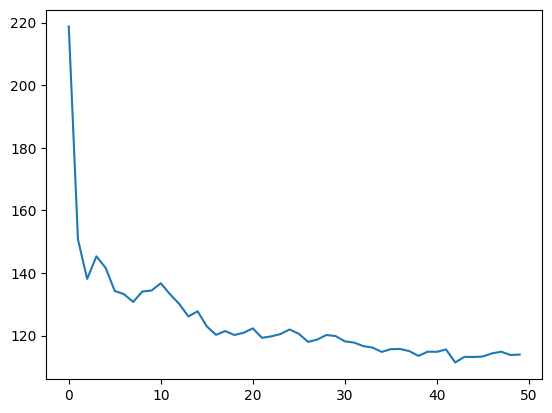

In [ ]:
plt.plot(fid_)

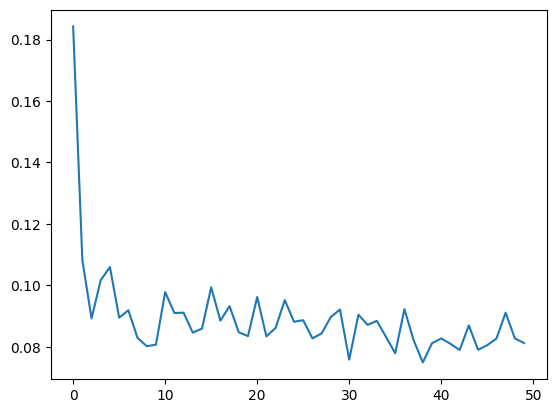

In [ ]:
plt.plot(kid_mean_)

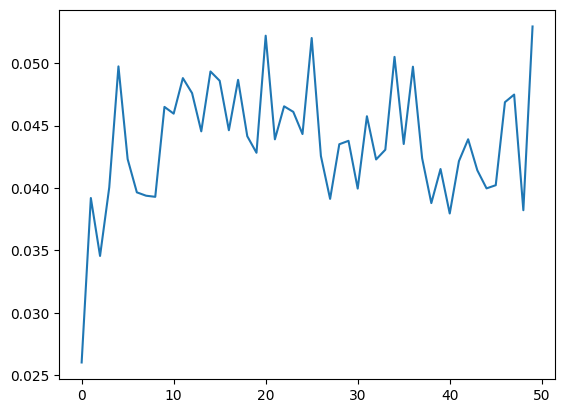

In [ ]:
plt.plot(kid_std_)

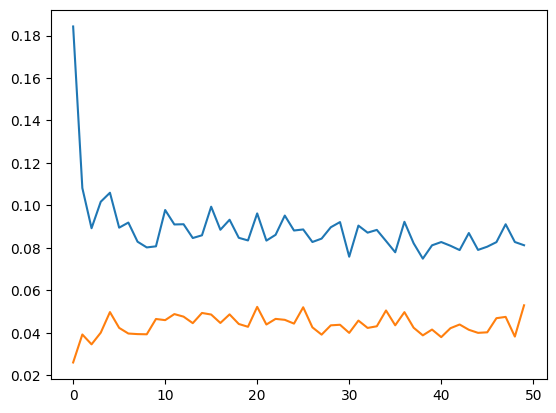

In [ ]:
plt.plot(kid_score)

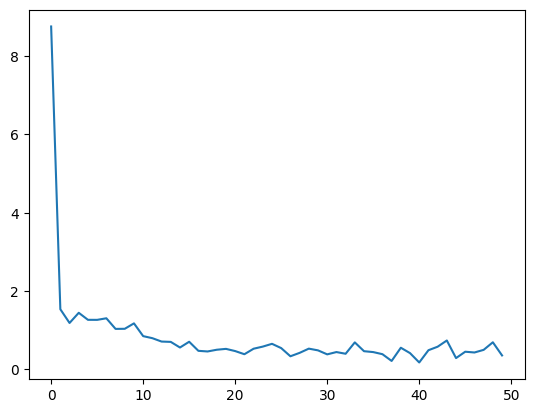

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0816), tensor(0.0379))